In [11]:
import os
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scipy.io as sio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
NUM_EPOCHS = 200

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 4
NUM_CHANNELS = 2

In [91]:
mat_contents = sio.loadmat('noma_spectrum_sensing_data.mat') 
CC = mat_contents['CC']
N = CC.shape[0]
theta = mat_contents['theta'].reshape(N)
x = torch.tensor(CC).float()
y = torch.tensor(theta).long()

In [92]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.5, shuffle=True)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [93]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, num_channels):
        super(LeNet5, self).__init__()
        
        in_channels = num_channels
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [94]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn-v0_8-whitegrid')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(xlabel='Epoch', ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    fig.savefig('iteration.jpg', dpi=600)
    with open('snr_3.npy', 'wb') as f:
        np.save(f, train_losses)
        np.save(f, valid_losses)
        
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [95]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, NUM_CHANNELS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

09:03:09 --- Epoch: 0	Train loss: 1.5153	Valid loss: 1.4699	Train accuracy: 23.36	Valid accuracy: 25.34
09:03:10 --- Epoch: 1	Train loss: 1.3496	Valid loss: 1.3695	Train accuracy: 45.06	Valid accuracy: 46.76
09:03:10 --- Epoch: 2	Train loss: 0.8483	Valid loss: 0.6058	Train accuracy: 75.00	Valid accuracy: 75.36
09:03:11 --- Epoch: 3	Train loss: 0.5429	Valid loss: 0.6226	Train accuracy: 74.68	Valid accuracy: 74.80
09:03:11 --- Epoch: 4	Train loss: 0.2014	Valid loss: 0.1395	Train accuracy: 96.54	Valid accuracy: 94.66
09:03:12 --- Epoch: 5	Train loss: 0.0813	Valid loss: 0.0534	Train accuracy: 99.22	Valid accuracy: 98.36
09:03:13 --- Epoch: 6	Train loss: 0.0442	Valid loss: 0.1185	Train accuracy: 96.94	Valid accuracy: 95.92
09:03:13 --- Epoch: 7	Train loss: 0.0464	Valid loss: 0.0685	Train accuracy: 98.82	Valid accuracy: 97.04
09:03:14 --- Epoch: 8	Train loss: 0.0275	Valid loss: 0.0582	Train accuracy: 99.66	Valid accuracy: 98.28
09:03:14 --- Epoch: 9	Train loss: 0.0227	Valid loss: 0.0707	Trai

C:\Users\SM\AppData\Local\Temp\ipykernel_9296\3619158214.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


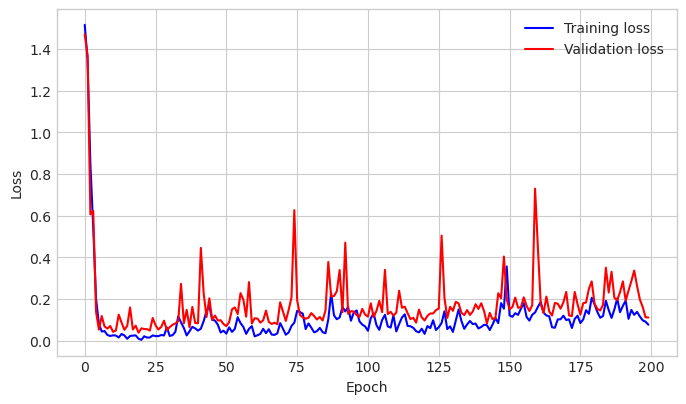

In [96]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, NUM_EPOCHS, DEVICE)